## DayTrade System

In [64]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

### Constants and Parameters

In [65]:
dfColumns = ['date','open', 'high', 'low','close','volume']
newColumns = ['open', 'high', 'low', 'close']
col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']
DAYS = 5
TEST_BEGIN = '2021.04.06'
TEST_END = '2021.06.01'
TRAIN_BEGIN = '2020.03.31'
TRAIN_END = '2021.05.31'
TIMES = 10

### Auxiliary functions

In [66]:
def calculateEMA(df, n, columns):
    """
    returns an n period exponential moving average for
    the time series s

    pd.Dataframe df: is the original dataframe - it needs to contain a 'Close' named column
    int          n: is the number of periods to consider in the calculus

    returns a dataframe with a new column containing the MME
    """
    
    k  = 2 / (n+1)
    for column in columns:
        EMAcolumn = 'EMA_'+column

        df[EMAcolumn] = df[column]
        df[EMAcolumn].iloc[n-1] = df[column].iloc[0:n-2].mean()

        for i in range(n, len(df)):
            df[EMAcolumn].iloc[i] = (df[column].iloc[i] - df[EMAcolumn].iloc[i-1])*k + df[EMAcolumn].iloc[i-1]
            #MME = (Close[i] - MME[i-1])*k + MME[i-1] 
     
    #The following function makes all the hardwork. However I'll keep it commented, once I've already implemented the calculation
    #f['pandasEMA'] = df['close'].ewm(span=5, adjust=False).mean()
    
    return df

def calculateBB(df, n, columns):
    ma = df['close'].rolling(window=n).mean()
    std = df['close'].rolling(window=n).std() 
    
    for column in columns:
        df['UB_'+column] = ma + (std * 2)
        df['LB_'+column] = ma - (std * 2)
    
    return df

def removeColumns(df, columns):
    df = df.drop(columns, axis=1)
    return df

def addPreviousDays(df, days, columns):
    auxDf = df
    for day in range(1,days+1):
        for column in columns:
            colName = 'd-'+str(day)+'_'+column
            df[colName] = auxDf[column].shift(day)
    return df

def getPeriod(df, begin, end, resetIndex = False):
    """
    returns the df in the chosen interval
    
    Object begin: Start date forrmated as 'yyyy.mm.dd'
    Object   end: end date 'yyyy.mm.dd'

    returns a dataframe with the historic of the selected period
    """
    indexBegin = df[df['date']==begin].index[0]
    indexEnd = df[df['date']==end].index[0]
    
    if (resetIndex):
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)].reset_index(drop=True)
    else: 
        return df[(df.index >= indexBegin) & (df.index <= indexEnd)]
    
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100, np.std(np.abs((actual - pred) / actual)) * 100

def mae(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs(actual - pred)), np.std(np.abs(actual - pred))

def Normalize(df):
    date = df['date']
    maxVal = df[['high', 'low']].max()
    normalized = removeColumns(df,['date'])/(removeColumns(df,['date']).max()*2)
    
    
    df.loc[:, df.columns != 'date'] = normalized
    
    return df, maxVal

def createDate(day, month, year):
    if(day >= 10):
        day = str(day)
    else:
        day = '0' + str(day)
    
    if(month < 10):
        month = '0' + str(month)
    else:
        month = str(month)
        
    year = str(year)
    date = year + '.' + month + '.' + day
    
    return date

def getDate(date):
    
    split = date.split('.')
    
    year = int(split[0])
    month = int(split[1])
    day = int(split[2])
    
    return year, month, day
 
def printResult(error, column):
    print(column+': '+str(error[0].round(2))+' +- '+str(error[1].round(2)) + ' %')

### Opening the dataset

In [67]:
df = pd.read_parquet('dfbtc_15m.parquet')#, sep = "\t")
df.columns = dfColumns
# df = removeColumns(df, ['tickvol', 'volume','spread'])
df = removeColumns(df, ['volume'])

# df2 = pd.read_parquet('Data/VALE3_Daily.csv', sep = "\t")

# df2.columns = dfColumns
# df2 = removeColumns(df2, ['tickvol', 'volume','spread'])

df 
df.tail(290)

,date,open,high,low,close
1970-01-01 00:02:45.604,2023-09-24 20:30:00,26437.76,26485.89,26437.76,26470.45
1970-01-01 00:02:45.605,2023-09-24 20:45:00,26470.45,26511.95,26465.33,26502.00
1970-01-01 00:02:45.606,2023-09-24 21:00:00,26502.01,26519.52,26461.95,26462.70
1970-01-01 00:02:45.607,2023-09-24 21:15:00,26462.69,26492.86,26450.00,26490.01
1970-01-01 00:02:45.608,2023-09-24 21:30:00,26490.00,26494.12,26481.45,26494.11
...,...,...,...,...,...
1970-01-01 00:02:45.889,2023-09-27 19:45:00,26257.22,26267.81,26253.77,26267.80
1970-01-01 00:02:45.890,2023-09-27 20:00:00,26267.81,26267.81,26249.95,26249.95
1970-01-01 00:02:45.891,2023-09-27 20:15:00,26249.95,26294.00,26249.95,26285.00
1970-01-01 00:02:45.892,2023-09-27 20:30:00,26285.00,26285.01,26228.05,26230.71


In [68]:
#PETR4
df = calculateEMA(df,DAYS,newColumns)
df = calculateBB(df,DAYS,newColumns)
df = addPreviousDays(df,DAYS, newColumns)

#VALE3
# df2 = calculateEMA(df2,DAYS,newColumns)
# df2 = calculateBB(df2,DAYS,newColumns)
# df2 = addPreviousDays(df2,DAYS, newColumns)

In [69]:
##df = getPeriod(df, '2020.03.02','2021.04.30', True)
initialDf = getPeriod(df, '2020.03.02','2021.04.30', True)

In [70]:
initialDf_PETR4 = getPeriod(df, '2019.01.02','2021.06.01', True)
# initialDf_VALE3 = getPeriod(df2, '2020.01.02','2021.06.01', True)

In [71]:
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2019-01-02 00:00:00,3796.45,3810.00,3785.49,3787.54,3770.618956,3789.426722,3760.794379,3776.444783,3841.408292,...,3720.00,3801.90,3712.85,3730.00,3706.43,3725.54,3712.90,3717.07,3710.28,3711.20
1,2019-01-02 00:15:00,3787.53,3792.14,3765.42,3777.38,3776.255971,3790.331148,3762.336252,3776.756522,3809.333897,...,3780.00,3785.62,3724.31,3810.16,3720.00,3801.90,3712.85,3730.00,3706.43,3725.54
2,2019-01-02 00:30:00,3777.39,3779.97,3763.75,3770.37,3776.633980,3786.877432,3762.807502,3774.627682,3804.022163,...,3779.08,3797.14,3801.93,3808.80,3780.00,3785.62,3724.31,3810.16,3720.00,3801.90
3,2019-01-02 00:45:00,3772.72,3782.92,3770.58,3778.02,3775.329320,3785.558288,3765.398334,3775.758454,3802.882124,...,3785.49,3787.54,3785.29,3798.00,3779.08,3797.14,3801.93,3808.80,3780.00,3785.62
4,2019-01-02 01:00:00,3778.62,3792.00,3773.70,3776.29,3776.426214,3787.705525,3768.165556,3775.935636,3790.269308,...,3765.42,3777.38,3796.45,3810.00,3785.49,3787.54,3785.29,3798.00,3779.08,3797.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84333,2021-05-31 23:00:00,36879.23,37059.93,36800.93,37030.00,36936.966550,37066.843951,36834.101152,36967.951259,37276.214091,...,37081.54,37090.16,36932.55,37250.00,36863.28,37190.46,36782.38,37087.30,36665.09,36932.55
84334,2021-05-31 23:15:00,37030.00,37345.00,36985.00,37301.51,36967.977700,37159.562634,36884.400768,37079.137506,37378.865371,...,36888.00,36912.90,37190.46,37215.53,37081.54,37090.16,36932.55,37250.00,36863.28,37190.46
84335,2021-05-31 23:30:00,37301.51,37499.00,37231.13,37388.01,37079.155134,37272.708422,36999.977178,37182.095004,37562.954249,...,36835.85,36879.23,37090.16,37140.00,36888.00,36912.90,37190.46,37215.53,37081.54,37090.16
84336,2021-05-31 23:45:00,37388.01,37394.30,37246.33,37253.81,37182.106756,37313.238948,37082.094786,37206.000003,37590.027481,...,36800.93,37030.00,36912.89,36997.17,36835.85,36879.23,37090.16,37140.00,36888.00,36912.90


#### Experimento 1: Benchmark

In [72]:
def exp01(df):
    df = df[['date','open', 'high', 'low', 'close']]
    
    df = df[['date','open', 'high', 'low', 'close']]

    minaux = df['low'].copy()
    maxaux = df['high'].copy()

    df['maxonedaylag'] = df['high'].shift(1)
    df['minonedaylag'] = df['low'].shift(1)

    df['maxSma5'] = df['high'].rolling(window=5).mean()
    df['minSma5'] = df['low'].rolling(window=5).mean()

    df['maxSma10'] = df['high'].rolling(window=10).mean()
    df['minSma10'] = df['low'].rolling(window=10).mean()

    df['maxSma20'] = df['high'].rolling(window=20).mean()
    df['minSma20'] = df['low'].rolling(window=20).mean()
    
    df = getPeriod(df, TEST_BEGIN, TEST_END)
    
    return df

def printExp01(df, stock):
    print(stock)
    
    print("1-day lag: ")
    printResult(mape(df['high'],df['maxonedaylag']), 'High')
    printResult(mape(df['low'],df['minonedaylag']), 'Low')
    #print (mae(df['high'],df['maxonedaylag']))
    #print (mae(df['low'],df['minonedaylag']))

    print("SMA5: ")
    printResult(mape(df['high'],df['maxSma5']), 'High')
    printResult(mape(df['low'],df['minSma5']), 'Low')
    #print (mae(df['high'],df['maxSma5']))
    #print (mae(df['low'],df['minSma5']))

    print("SMA10: ")
    printResult(mape(df['high'],df['maxSma10']), 'High')
    printResult(mape(df['low'],df['minSma10']), 'Low')
    #print (mae(df['high'],df['maxSma10']))
    #print (mae(df['low'],df['minSma10']))

    print("SMA20: ")
    printResult(mape(df['high'],df['maxSma20']), 'High')
    printResult(mape(df['low'],df['minSma20']), 'Low')
    #print (mae(df['high'],df['maxSma20']))
    #print (mae(df['low'],df['minSma20']))
    
aux = getPeriod(initialDf_PETR4, TRAIN_BEGIN, TEST_END)
exp1 = exp01(aux)

printExp01(exp1, 'PETR4')

# aux = getPeriod(initialDf_VALE3, TRAIN_BEGIN, TEST_END)
# exp1 = exp01(aux)

# printExp01(exp1, 'VALE3')

PETR4
1-day lag: 
High: 0.33 +- 0.39 %
Low: 0.38 +- 0.53 %
SMA5: 
High: 0.38 +- 0.42 %
Low: 0.44 +- 0.61 %
SMA10: 
High: 0.6 +- 0.63 %
Low: 0.68 +- 0.87 %
SMA20: 
High: 0.89 +- 0.93 %
Low: 1.01 +- 1.21 %


#### Experimento 02: Rodando MLP para testes

In [73]:
def exp02(df, stock, inputColumns = []):
    df = getPeriod(df, TRAIN_BEGIN, TEST_END, True)
    
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)

    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]
    

    MLP = MLPRegressor(hidden_layer_sizes = (8), #sqrt(33*2) according to the article
                       momentum = 0.8,
                       max_iter = 100000,
                       activation = 'relu',
                       learning_rate = 'constant',
                       learning_rate_init = 0.01)

    MLP.fit(x_train, y_train)
    y_pred = MLP.predict(x_test)
    
    errorMax = mape(y_test['high'],y_pred[:,0])
    errorMin = mape(y_test['low'],y_pred[:,1])
    #printResult(mape(y_test['high'],y_pred[:,0]), 'High')
    #printResult(mape(y_test['low'],y_pred[:,1]), 'Low')
    #print (mae(y_test['high'],y_pred[:,0]))
    #print (mae(y_test['low'],y_pred[:,1]))
    
    return errorMax, errorMin

def test30timesExp02(df,stock, phrase, columnInput = []):
    errorMax = []
    errorMin = []
    
    for i in range(1, TIMES+1):
        if(columnInput == []):
            errorMax_petr4, errorMin_petr4 = exp02(df, stock)
        else: 
            errorMax_petr4, errorMin_petr4 = exp02(df, stock, columnInput)
        
        errorMax.append(errorMax_petr4[0])
        errorMin.append(errorMin_petr4[0])
    
    errorMax = np.array(errorMax)
    errorMin = np.array(errorMin)
    print(phrase)
    printResult((errorMax.mean(),errorMax.std()), 'High')
    printResult((errorMin.mean(),errorMin.std()), 'Low')
    
    
test30timesExp02(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
test30timesExp02(initialDf_PETR4, 'PETR4', 'PETR4 25 Variables', col25) 
test30timesExp02(initialDf_PETR4, 'PETR4', 'PETR4 33 Variables') 
print('\n')
# test30timesExp02(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15) 
# test30timesExp02(initialDf_VALE3, 'VALE3', 'VALE3 25 Variables', col25) 
# test30timesExp02(initialDf_VALE3, 'VALE3', 'VALE3 33 Variables') 

PETR4 15 Variables
High: 0.63 +- 0.2 %
Low: 0.78 +- 0.41 %
PETR4 25 Variables
High: 1.46 +- 1.28 %
Low: 1.55 +- 0.88 %
PETR4 33 Variables
High: 0.95 +- 0.92 %
Low: 0.77 +- 0.47 %




#### Experimento 03: Reproduzindo o experimento realizado por Martinez

In [74]:
def exp03(df, stock, inputColumns = []):
    aux, maxVal = Normalize(df)
    df = aux
    
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]
    
    MLP = MLPRegressor(hidden_layer_sizes = (8), #sqrt(33*2) according to the article
                   momentum = 0.8,
                   max_iter = 100000,
                   activation = 'logistic',
                   learning_rate = 'constant',
                   learning_rate_init = 0.01)

    MLP.fit(x_train, y_train)
    y_pred = MLP.predict(x_test)
    
    y_predFix = y_pred
    y_predFix[:,0] = y_predFix[:,0]*maxVal['high']*2
    y_predFix[:,1] = y_predFix[:,1]*maxVal['low']*2

    y_testFix = y_test*maxVal*2
    
    #print(stock)
    
    errorMax = mape(y_testFix['high'],y_predFix[:,0])
    errorMin = mape(y_testFix['low'],y_predFix[:,1])
    ##printResult(mape(y_testFix['high'],y_predFix[:,0]), 'High')
    ##printResult(mape(y_testFix['low'],y_predFix[:,1]), 'Low')
    #print (mae(y_testFix['high'],y_predFix[:,0]))
    #print (mae(y_testFix['low'],y_predFix[:,1]))
    
    return errorMax, errorMin

def test30timesExp03(df,stock, phrase, columnInput = []):
    errorMax = []
    errorMin = []
    
    for i in range(1, TIMES+1):
        if(columnInput == []):
            errorMax_petr4, errorMin_petr4 = exp03(df, stock)
        else: 
            errorMax_petr4, errorMin_petr4 = exp03(df, stock, columnInput)
        
        errorMax.append(errorMax_petr4[0])
        errorMin.append(errorMin_petr4[0])
    
    errorMax = np.array(errorMax)
    errorMin = np.array(errorMin)
    print(phrase)
    printResult((errorMax.mean(),errorMax.std()), 'High')
    printResult((errorMin.mean(),errorMin.std()), 'Low')
    
test30timesExp03(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
test30timesExp03(initialDf_PETR4, 'PETR4', 'PETR4 25 Variables', col25) 
test30timesExp03(initialDf_PETR4, 'PETR4', 'PETR4 33 Variables') 
print('\n')
# test30timesExp03(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15) 
# test30timesExp03(initialDf_VALE3, 'VALE3', 'VALE3 25 Variables', col25) 
# test30timesExp03(initialDf_VALE3, 'VALE3', 'VALE3 33 Variables') 

PETR4 15 Variables
High: 0.74 +- 0.17 %
Low: 0.94 +- 0.22 %
PETR4 25 Variables
High: 1.08 +- 0.3 %
Low: 1.24 +- 0.26 %
PETR4 33 Variables
High: 0.91 +- 0.2 %
Low: 1.1 +- 0.25 %




#### USANDO MINMAXSCALER

In [75]:
import pandas as pd
from sklearn import preprocessing

df3 = getPeriod(initialDf, '2020.03.02','2021.04.30', True)

def Normalize2(df, columns):
    date = df['date']

    x = removeColumns(df,['date']).values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    normalized = pd.DataFrame(x_scaled)
    normalized.columns = columns[1:]
    
    df.loc[:, df.columns != 'date'] = normalized
    df.columns = columns
    
    return df

df3 = Normalize2(df3, df3.columns)
df3

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2020-03-02 00:00:00,0.076314,0.070844,0.077667,0.076296,0.071023,0.068234,0.073668,0.070934,0.065549,...,0.078617,0.076971,0.076828,0.071372,0.078334,0.076871,0.076804,0.071639,0.078343,0.076941
1,2020-03-02 00:15:00,0.076187,0.071094,0.077984,0.076473,0.070904,0.068193,0.073638,0.070912,0.065427,...,0.078381,0.076685,0.076787,0.071784,0.078617,0.076971,0.076828,0.071372,0.078334,0.076871
2,2020-03-02 00:30:00,0.076363,0.071397,0.078223,0.076869,0.070884,0.068268,0.073699,0.071031,0.065331,...,0.078195,0.076450,0.076848,0.071424,0.078381,0.076685,0.076787,0.071784,0.078617,0.076971
3,2020-03-02 00:45:00,0.076763,0.071461,0.078411,0.076880,0.071005,0.068339,0.073802,0.071114,0.065454,...,0.077667,0.076296,0.076582,0.071295,0.078195,0.076450,0.076848,0.071424,0.078381,0.076685
4,2020-03-02 01:00:00,0.076791,0.071259,0.078249,0.076648,0.071095,0.068319,0.073817,0.071091,0.065469,...,0.077984,0.076473,0.076314,0.070844,0.077667,0.076296,0.076582,0.071295,0.078195,0.076450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40605,2021-04-29 23:00:00,0.813818,0.812247,0.815527,0.813473,0.812860,0.813084,0.814630,0.813524,0.809836,...,0.812259,0.809612,0.812862,0.810454,0.814095,0.811820,0.807669,0.810437,0.810240,0.813008
40606,2021-04-29 23:15:00,0.813327,0.815166,0.816271,0.816573,0.813520,0.814577,0.815615,0.815007,0.812606,...,0.812607,0.811486,0.811674,0.809714,0.812259,0.809612,0.812862,0.810454,0.814095,0.811820
40607,2021-04-29 23:30:00,0.816427,0.814327,0.817801,0.816710,0.815003,0.815291,0.816786,0.816042,0.813195,...,0.813798,0.813964,0.809467,0.809867,0.812607,0.811486,0.811674,0.809714,0.812259,0.809612
40608,2021-04-29 23:45:00,0.816564,0.814978,0.819024,0.816721,0.816038,0.815986,0.817978,0.816735,0.813066,...,0.815527,0.813473,0.811340,0.811650,0.813798,0.813964,0.809467,0.809867,0.812607,0.811486


In [76]:
df_train = getPeriod(df3, '2020.03.02','2021.03.31')
df_test = getPeriod(df3, '2021.04.01','2021.04.30')

x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
y_train = df_train[['high','low']]

x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
y_test = df_test[['high','low']]
MLP = MLPRegressor(hidden_layer_sizes = (8), #sqrt(33*2) according to the article
                   momentum = 0.8,
                   max_iter = 100000,
                   activation = 'relu',
                   learning_rate = 'constant',
                   learning_rate_init = 0.01)

MLP.fit(x_train, y_train)
y_pred = MLP.predict(x_test)

print (mape(y_test['high'],y_pred[:,0]))
print (mape(y_test['low'],y_pred[:,1]))
print (mae(y_test['high'],y_pred[:,0]))
print (mae(y_test['low'],y_pred[:,1]))

(0.29132773252940497, 0.31391564377850156)
(0.4957152419993286, 0.490665979963799)
(0.0025103313545542087, 0.0026324829279688734)
(0.004308187695811458, 0.00397123922024344)


#### Experimento 04: Utilizando Random Forest

In [77]:
def exp04(df, stock, inputColumns = []):
    #df = getPeriod(df, '2020.03.02','2021.04.30', True)
    
    #print(df)
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    rf = RandomForestRegressor(n_estimators = 500)
    rf.fit(x_train, y_train);
    y_pred = rf.predict(x_test)
    
    errorMax = mape(y_test['high'],y_pred[:,0])
    errorMin = mape(y_test['low'],y_pred[:,1])
    
    #print (mape(y_test['high'],y_pred[:,0]))
    #print (mape(y_test['low'],y_pred[:,1]))
    #print (mae(y_test['high'],y_pred[:,0]))
    #print (mae(y_test['low'],y_pred[:,1]))
    
    return errorMax, errorMin

def test30timesExp04(df,stock, phrase, columnInput = []):
    errorMax = []
    errorMin = []
    
    for i in range(1, TIMES+1):
        if(columnInput == []):
            errorMax_petr4, errorMin_petr4 = exp04(df, stock)
        else: 
            errorMax_petr4, errorMin_petr4 = exp04(df, stock, columnInput)
            
        errorMax.append(errorMax_petr4[0])
        errorMin.append(errorMin_petr4[0])
    
    errorMax = np.array(errorMax)
    errorMin = np.array(errorMin)
    print(phrase)
    printResult((errorMax.mean(),errorMax.std()), 'High')
    printResult((errorMin.mean(),errorMin.std()), 'Low')
    
test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 15 Variables', col15) 
test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 25 Variables', col25) 
test30timesExp04(initialDf_PETR4, 'PETR4', 'PETR4 33 Variables') 
print('\n')
# test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 15 Variables', col15) 
# test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 25 Variables', col25) 
# test30timesExp04(initialDf_VALE3, 'VALE3', 'VALE3 33 Variables')     

KeyboardInterrupt: 

In [ ]:
df4 = getPeriod(initialDf, '2020.03.02','2021.04.30', True)

df_train = getPeriod(df4, '2020.03.02','2021.03.31')
df_test = getPeriod(df4, '2021.04.01','2021.04.30')

x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
y_train = df_train[['high','low']]

x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
y_test = df_test[['high','low']]

rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(x_train, y_train);
y_pred = rf.predict(x_test)

print (mape(y_test['high'],y_pred[:,0]))
print (mape(y_test['low'],y_pred[:,1]))
print (mae(y_test['high'],y_pred[:,0]))
print (mae(y_test['low'],y_pred[:,1]))

(2.5449707407130644, 1.9328602786197104)
(3.406134480380738, 2.732344224491334)
(1489.0091476666396, 1159.4936377067725)
(1901.2693339999562, 1537.5810289897347)


Feature: 0, Score: 0.03547
Feature: 1, Score: 0.04122
Feature: 2, Score: 0.02870
Feature: 3, Score: 0.04069
Feature: 4, Score: 0.04769
Feature: 5, Score: 0.02594
Feature: 6, Score: 0.01945
Feature: 7, Score: 0.02994
Feature: 8, Score: 0.02136
Feature: 9, Score: 0.02899
Feature: 10, Score: 0.02077
Feature: 11, Score: 0.02212
Feature: 12, Score: 0.02110
Feature: 13, Score: 0.03404
Feature: 14, Score: 0.01712
Feature: 15, Score: 0.03314
Feature: 16, Score: 0.04435
Feature: 17, Score: 0.01571
Feature: 18, Score: 0.02847
Feature: 19, Score: 0.03431
Feature: 20, Score: 0.02897
Feature: 21, Score: 0.03699
Feature: 22, Score: 0.02839
Feature: 23, Score: 0.02881
Feature: 24, Score: 0.01998
Feature: 25, Score: 0.01915
Feature: 26, Score: 0.03165
Feature: 27, Score: 0.03785
Feature: 28, Score: 0.02079
Feature: 29, Score: 0.03044
Feature: 30, Score: 0.04879
Feature: 31, Score: 0.04103
Feature: 32, Score: 0.03658


<BarContainer object of 33 artists>

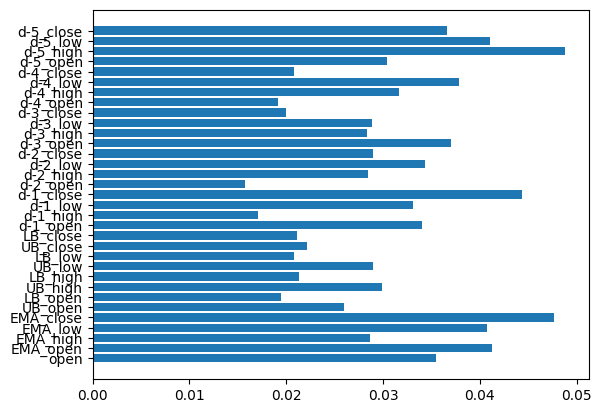

In [ ]:
importance = rf.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

importance

from matplotlib import pyplot as plt
plt.barh(x_train.columns, rf.feature_importances_)

In [ ]:
def exp041(df, stock, inputColumns = []):
    #df = getPeriod(df, '2020.03.02','2021.04.30', True)
    
    #print(df)
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    for i in range(1, 5):    
        rf = RandomForestRegressor(n_estimators = 1)
        rf.fit(x_train, y_train);
        y_pred = rf.predict(x_test)
        
        print(i)
        errorMax = mape(y_test['high'],y_pred[:,0])
        errorMin = mape(y_test['low'],y_pred[:,1])
        printResult(errorMax, 'High')
        printResult(errorMin, 'Low')
    
    importance = rf.feature_importances_
    
    featureImp = []
    for feat, importance in zip(x_train.columns, rf.feature_importances_):  
        temp = [feat, importance*100]
        featureImp.append(temp)

    fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
    print (fT_df.sort_values('Importance', ascending = False))
    
    #print (mape(y_test['high'],y_pred[:,0]))
    #print (mape(y_test['low'],y_pred[:,1]))
    #print (mae(y_test['high'],y_pred[:,0]))
    #print (mae(y_test['low'],y_pred[:,1]))
    
    return errorMax, errorMin, y_pred, y_test

# a,b,c,d = exp041(initialDf_VALE3, 'PETR4')

In [ ]:
# printResult(a, 'High')
# printResult(b, 'Low')

NameError: name 'a' is not defined

In [ ]:
# d

,high,low
559,23.58,23.13
560,23.55,23.15
561,23.26,22.61
562,23.01,22.61
563,23.58,23.01
564,23.33,22.92
565,23.78,23.20
566,23.83,23.02
567,23.24,22.81
568,24.89,22.77


In [ ]:
initialDf_PETR4

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2019-01-02,0.029858,0.029930,0.030236,0.030347,0.030604,0.030713,0.031028,0.031104,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,0.030339,0.029780,0.030071,0.029625,0.031097,0.030559,0.030859,0.030364,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,0.029628,0.029479,0.029858,0.029823,0.030368,0.030250,0.030640,0.030568,NaN,...,0.029361,0.029863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-05,0.029808,0.029613,0.030240,0.029658,0.030512,0.030472,0.030672,0.030693,0.029127,...,0.030236,0.030347,0.029109,0.029375,0.029361,0.029863,NaN,NaN,NaN,NaN
4,2019-01-06,0.029659,0.031052,0.030152,0.031361,0.030475,0.030936,0.030762,0.031176,0.030257,...,0.030071,0.029625,0.029858,0.029930,0.030236,0.030347,0.029109,0.029375,0.029361,0.029863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,2021-05-28,0.303028,0.299733,0.279619,0.280484,0.310752,0.316168,0.296035,0.302976,0.308023,...,0.293612,0.301413,0.272760,0.307768,0.274355,0.305122,0.294601,0.295052,0.250814,0.272554
878,2021-05-29,0.280470,0.287866,0.271144,0.272160,0.302993,0.309244,0.290106,0.294969,0.310838,...,0.304744,0.308627,0.305238,0.306780,0.293612,0.301413,0.272760,0.307768,0.274355,0.305122
879,2021-05-30,0.272160,0.281309,0.269099,0.280309,0.294982,0.302386,0.285453,0.292415,0.306908,...,0.299373,0.303028,0.301413,0.314869,0.304744,0.308627,0.305238,0.306780,0.293612,0.301413
880,2021-05-31,0.280309,0.289103,0.275345,0.292991,0.292425,0.300479,0.284487,0.295045,0.296753,...,0.279619,0.280484,0.308627,0.311555,0.299373,0.303028,0.301413,0.314869,0.304744,0.308627
